Modelling Wine Quality Based on Physicochemical Properties

Wine is a popular alcoholic beverage and is often rated based on its production quality and typicity, or how the wine can exhibit the style and traits of the region it’s from. Vinho verde is a wine that comes from the northern regions of Portugal. The white variety is characterised by its fresh acidity with an alcoholic content of 8.5% - 11%. The red variety tastes tannic and is more tart. Moreover, it tends to be lower in alcohol content, around 8%. 


For our project, we would like to answer the question: can we predict the quality rating of a vinho verde wine based on its physicochemical properties using the dataset available to us? We will be using two wine quality datasets, one for the white variety of vinho verde and one for the red variety. The datasets contain information about the physicochemical properties of vinho verde wines with quality ratings given by experts. Columns in our dataset include: fixed acidity (g / dm^3), volatile acidity ( g / dm^3), citric acid (g / dm^3), residual sugar (g / dm^3), chlorides (g / dm^3), free sulfur dioxide (mg / dm^3), total sulfur dioxide (mg / dm^3), density (g / cm^3), pH, sulphates (g / dm^3), alcohol (% by volume) and quality (score between 0 and 10). We choose to use all the columns as preliminary variables to conduct our analysis because these variables affect the production and flavour of wine. 

It is important to note the limitations of this dataset. None of the white wines have a rating of 1,2 or 10. Meanwhile, none of the red wines have a rating of 1,2,9 or 10. Therefore, the lowest rating we can predict for red and white vinho verde wine is 3; the highest rating we can predict for red vinho verde is 8 and the highest rating we can predict for white vinho verde is 9. In addition, there are many more wines with a rating of 5 or 6 compared to wines with lower or greater scores. Therefore, we will rebalance the data by replicating the infrequent cases.

We will use the K-nearest neighbours classification algorithm for our classification model. First, we will clean and wrangle our data. Then, we will randomly split the data into a training and testing set. Using the training set, we will create a preprocessor to standardise and balance the data. We will create a classifier using the training set at K = 3, and predict our test set. Finally, we will compute our accuracy and tune our classification model using cross-validation, best subset selection and forward selection.

We hope to achieve an accuracy that is good enough to classify the quality of wine given an observation with an unknown rating. Our findings can help producers and sellers evaluate the quality of their products and can be useful for marketing or targeting consumer preferences. Relating to our work or wine quality classification, future analysis can explore what physicochemical variables affect wine quality the most.


Word Count: 500

## Dataset Attributions

- P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.
- Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


Data url : https://archive.ics.uci.edu/ml/datasets/Wine+Quality


# Preliminary exploratory data analysis

In [47]:
# Libaries
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

- **Demonstrate that the dataset can be read from the web into R**
- **Clean and wrangle your data into a tidy format**

In [48]:
# Reading the data using read_delim 
# using read_delim and taking it from a url, however taking the csv file from the original website also works)
# Changing column names so they have underscores using colnames
# Mutating quality column into a factor so it can be used as a class for classification

red_wine_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
white_wine_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"

red_data <- read_delim(red_wine_url, delim = ";")

colnames(red_data) <- c("fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", 
                             "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide", "density", 
                             "ph", "sulfates", "alcohol", "quality")

white_data <- read_delim(white_wine_url, delim = ";")

colnames(white_data) <- c("fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", 
                             "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide", "density", 
                             "ph", "sulfates", "alcohol", "quality")


red_data
white_data

Parsed with column specification:
cols(
  `fixed acidity` = col_double(),
  `volatile acidity` = col_double(),
  `citric acid` = col_double(),
  `residual sugar` = col_double(),
  chlorides = col_double(),
  `free sulfur dioxide` = col_double(),
  `total sulfur dioxide` = col_double(),
  density = col_double(),
  pH = col_double(),
  sulphates = col_double(),
  alcohol = col_double(),
  quality = col_double()
)

Parsed with column specification:
cols(
  `fixed acidity` = col_double(),
  `volatile acidity` = col_double(),
  `citric acid` = col_double(),
  `residual sugar` = col_double(),
  chlorides = col_double(),
  `free sulfur dioxide` = col_double(),
  `total sulfur dioxide` = col_double(),
  density = col_double(),
  pH = col_double(),
  sulphates = col_double(),
  alcohol = col_double(),
  quality = col_double()
)



fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulfates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.3,0.510,0.13,2.3,0.076,29,40,0.99574,3.42,0.75,11.0,6
5.9,0.645,0.12,2.0,0.075,32,44,0.99547,3.57,0.71,10.2,5
6.0,0.310,0.47,3.6,0.067,18,42,0.99549,3.39,0.66,11.0,6


fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulfates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6
6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.5,0.24,0.19,1.2,0.041,30,111,0.99254,2.99,0.46,9.4,6
5.5,0.29,0.30,1.1,0.022,20,110,0.98869,3.34,0.38,12.8,7
6.0,0.21,0.38,0.8,0.020,22,98,0.98941,3.26,0.32,11.8,6


- **Using only training data, summarize the data in at least one table (this is exploratory data analysis).**
    - **An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data.**

In [49]:
#Let's split our data into testing and training data, and look at the training data so we can apply exploraty analysis

set.seed(1)
red_split<-initial_split(red_data, prop=0.75, strata = quality)
red_train<-training(red_split)
red_test<-testing(red_split)

white_split<-initial_split(white_data, prop=0.75, strata = quality)
white_train<-training(white_split)
white_test<-testing(white_split)

red_train
white_train

fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulfates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
5.9,0.550,0.10,2.2,0.062,39,51,0.99512,3.52,0.76,11.2,6
6.3,0.510,0.13,2.3,0.076,29,40,0.99574,3.42,0.75,11.0,6
5.9,0.645,0.12,2.0,0.075,32,44,0.99547,3.57,0.71,10.2,5


fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulfates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6
6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.2,0.21,0.29,1.6,0.039,24,92,0.99114,3.27,0.50,11.2,6
5.5,0.29,0.30,1.1,0.022,20,110,0.98869,3.34,0.38,12.8,7
6.0,0.21,0.38,0.8,0.020,22,98,0.98941,3.26,0.32,11.8,6


In [50]:
#Let's summarize the data by figuring out how many wines are in each class (each quality ranking)
set.seed(1)
red_wine_quality_count<- red_train %>% 
                       group_by(quality) %>%
                       summarize(count = n())
red_wine_quality_count

white_wine_quality_count<- white_train %>% 
                       group_by(quality) %>%
                       summarize(count = n())
white_wine_quality_count

`summarise()` ungrouping output (override with `.groups` argument)



quality,count
<dbl>,<int>
3,8
4,41
5,509
6,479
7,148
8,15


`summarise()` ungrouping output (override with `.groups` argument)



quality,count
<dbl>,<int>
3,14
4,122
5,1094
⋮,⋮
7,667
8,124
9,4


- **Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis).**
    - **An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.**

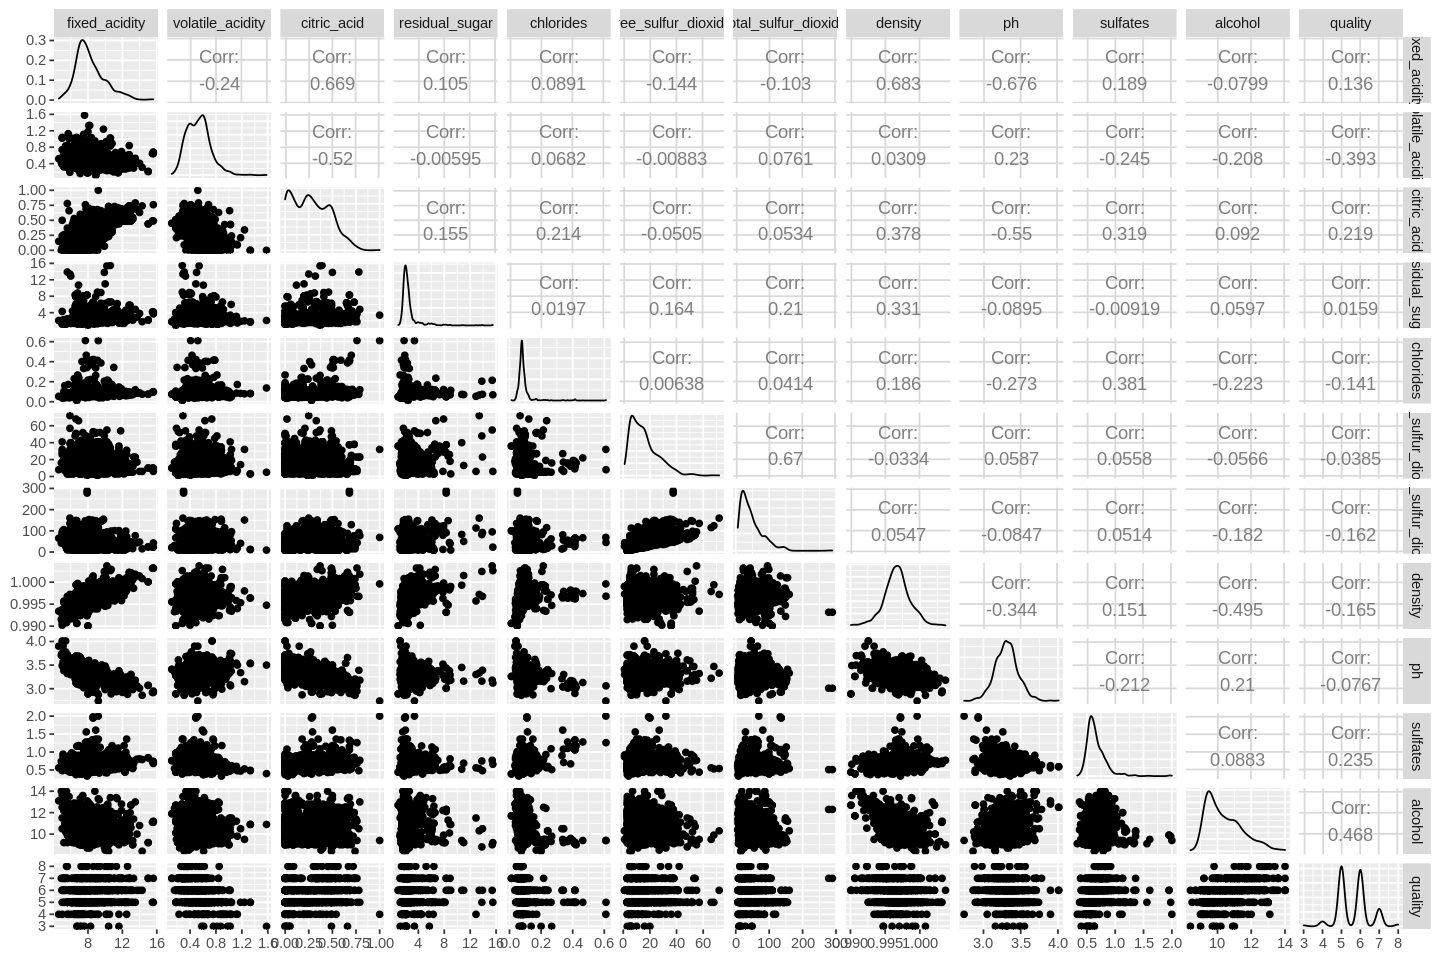

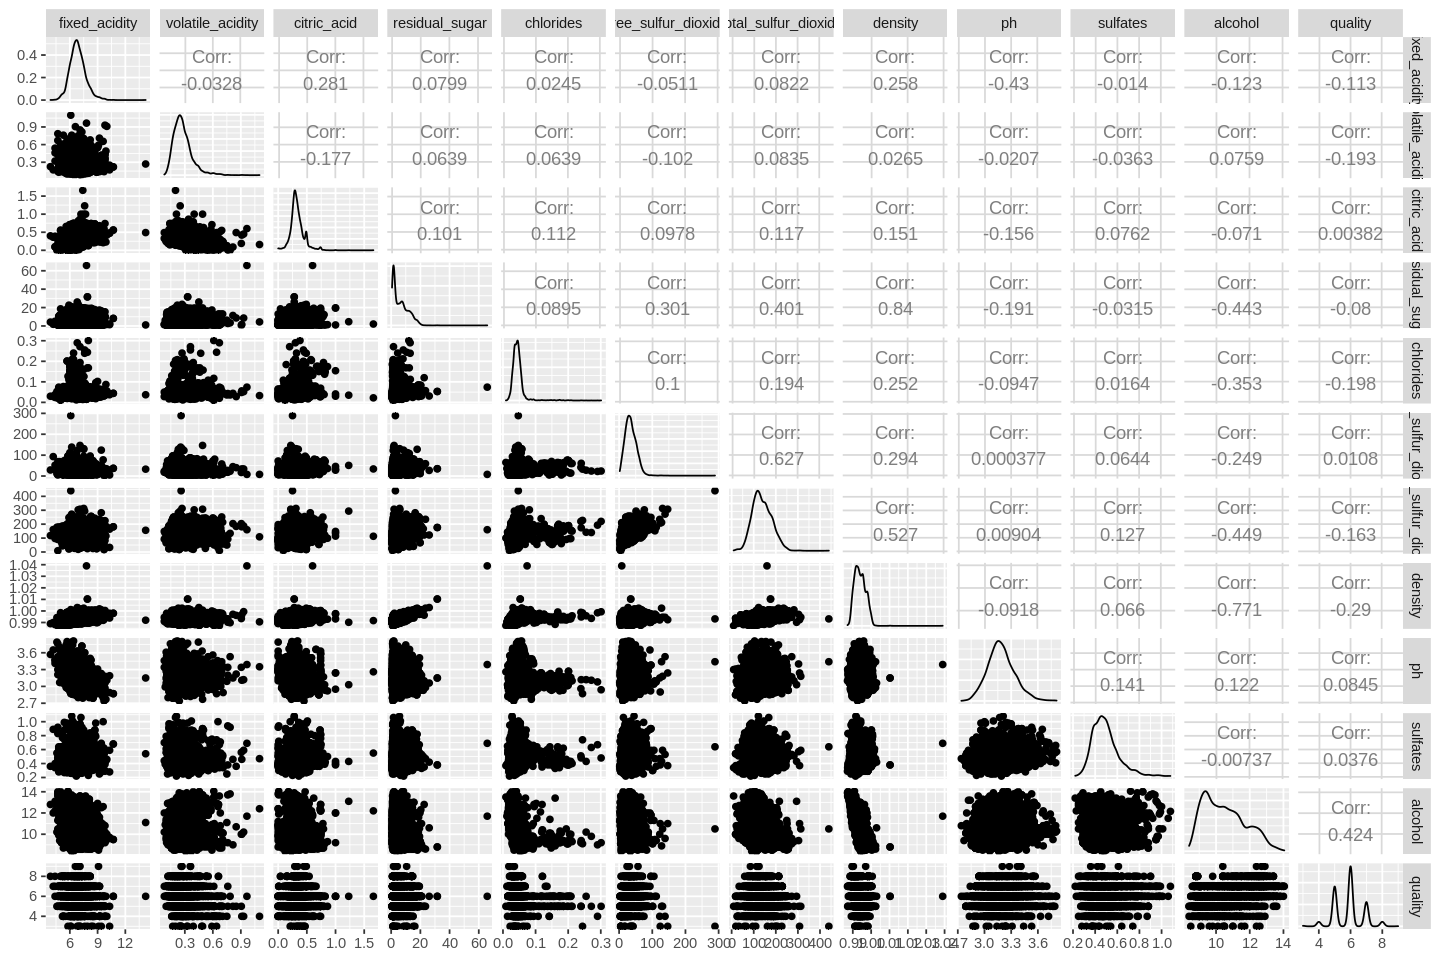

In [51]:
#Let's make some visualization to see how different variables affect eachother, and how they relate to the class (quality)
#Let's use the ggpairs function to determine which variables are related to quality the most, to begin deciding what we want to use as predictor variables

set.seed(1)
red_plot_intro<- ggpairs(red_train)
white_plot_intro<-ggpairs(white_train)

red_plot_intro
white_plot_intro



As we can see, for red wines, alcohol (0.485), sulfates (0.255), citric acidity (0.214), and volatile acidity (-0.384) have the highest correlation coefficients. For white wines, the highest correlation coefficients are alcohol (0.436, density (0.294), chlorides (0.217), volatile acidity (0.211).

In [52]:
#Let's now go through forward selection to figure out the best selection of predictors

#Select the variables mentioned above (the top 4 variables for each wine level) and extract column names
wine_r_subset <- red_train %>%
  select(quality, 
         alcohol, 
         sulfates, 
         citric_acid, 
         volatile_acidity, 
         density, 
         chlorides)

names <- colnames(wine_r_subset %>%
                  select(-quality))

wine_r_subset

quality,alcohol,sulfates,citric_acid,volatile_acidity,density,chlorides
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5,9.8,0.68,0.00,0.88,0.9968,0.098
5,9.8,0.65,0.04,0.76,0.9970,0.092
5,9.4,0.56,0.00,0.70,0.9978,0.076
⋮,⋮,⋮,⋮,⋮,⋮,⋮
6,11.2,0.76,0.10,0.550,0.99512,0.062
6,11.0,0.75,0.13,0.510,0.99574,0.076
5,10.2,0.71,0.12,0.645,0.99547,0.075


In [53]:
#Now we will write the forward selection code

set.seed(1)
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("regression")

# create a 5-fold cross-validation object
wine_r_vfold <- vfold_cv(wine_r_subset, v = 5, strata = quality)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("quality", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        wine_r_recipe <- recipe(as.formula(model_string), 
                                data = wine_r_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(wine_r_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = wine_r_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "rmse") %>%
          summarize(mx = min(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>%
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,quality ~ density,0.8310581
2,quality ~ density+chlorides,0.8100336
3,quality ~ density+chlorides+citric_acid,0.7604256
4,quality ~ density+chlorides+citric_acid+volatile_acidity,0.7274545
5,quality ~ density+chlorides+citric_acid+volatile_acidity+sulfates,0.6993879
6,quality ~ density+chlorides+citric_acid+volatile_acidity+sulfates+alcohol,0.6721354


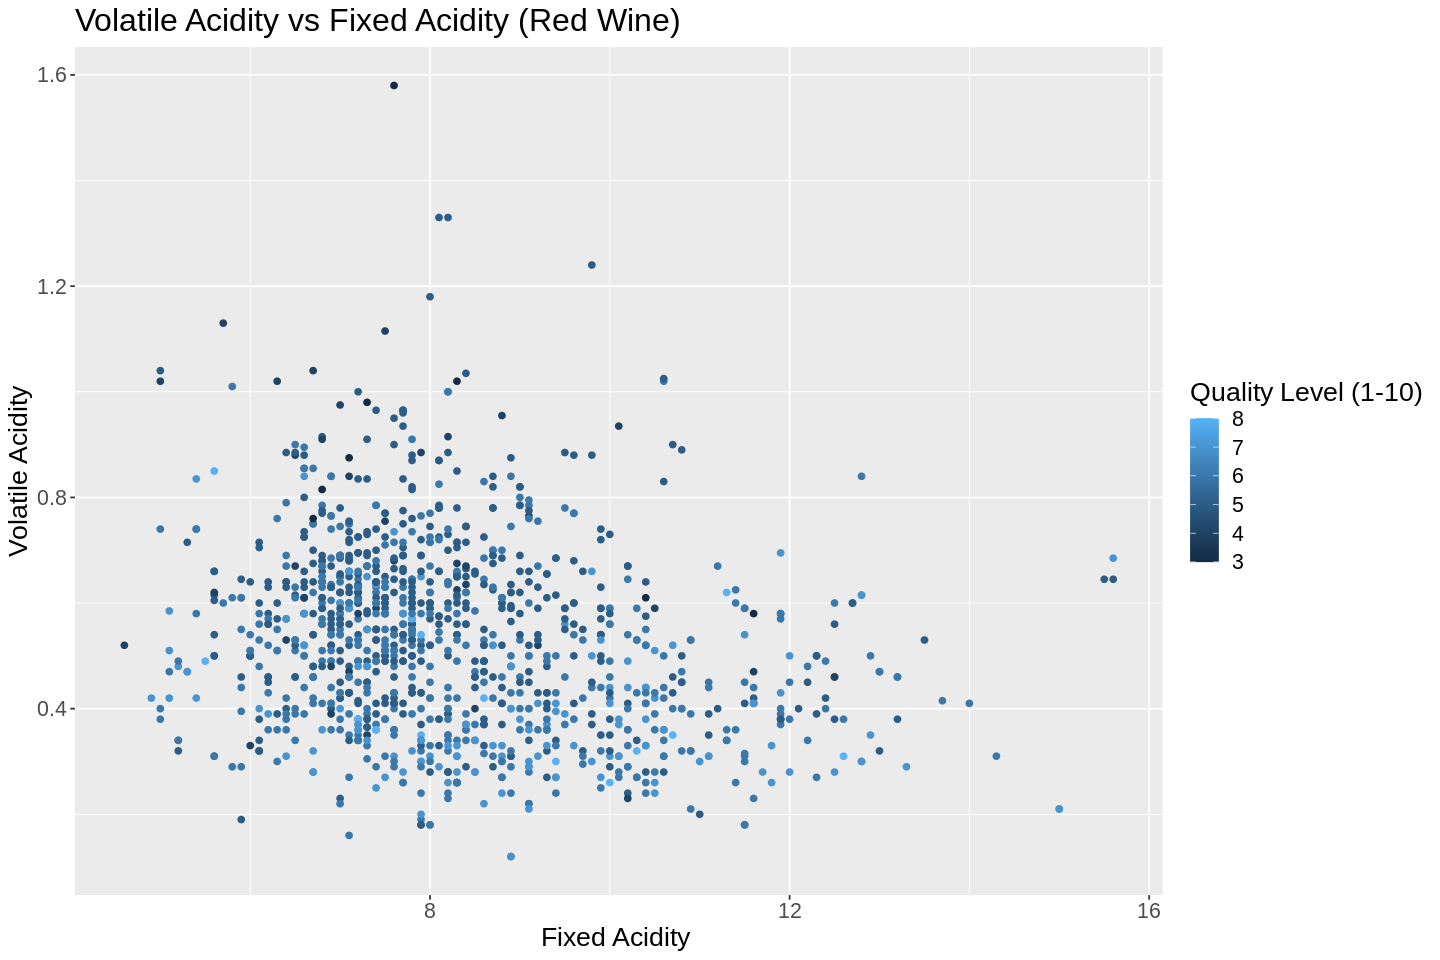

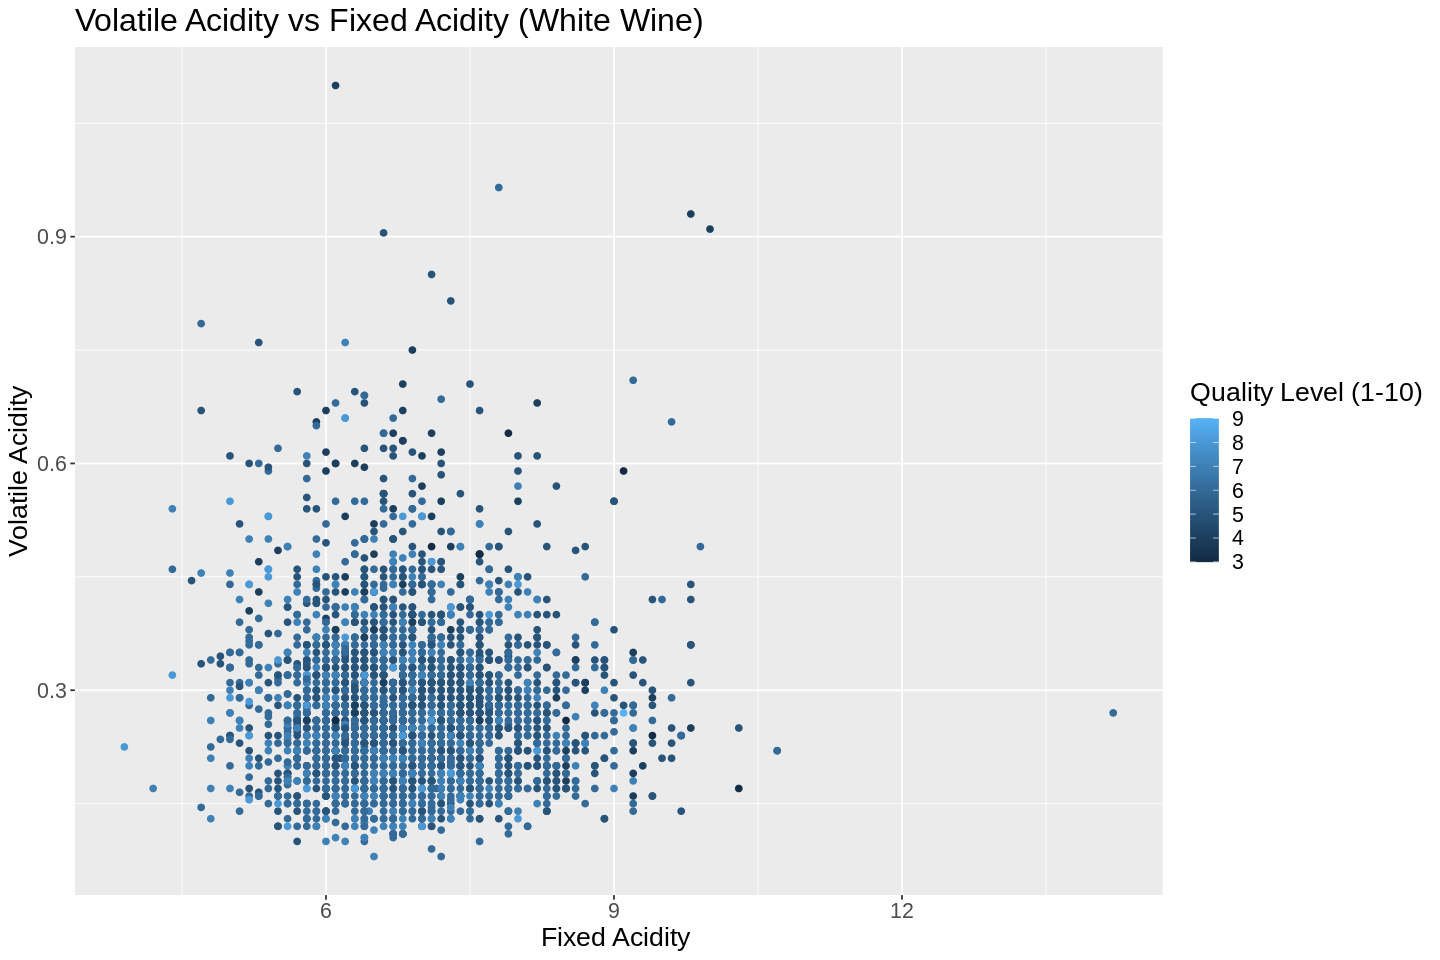

In [54]:
#Let's make some visualization to see how different variables affect eachother, and how they relate to the class (quality)
#Plotting types of acidity and observing whether there is a pattern in quality level
options(repr.plot.width = 12, repr.plot.height = 8)
acidity_plot_r<-ggplot(red_train, aes(x = fixed_acidity, y = volatile_acidity, colour = quality)) +
    ggtitle("Volatile Acidity vs Fixed Acidity (Red Wine)") +
    geom_point() +
    labs(x = "Fixed Acidity ", y = "Volatile Acidity", colour = "Quality Level (1-10)") +
    theme(text = element_text(size = 16))

acidity_plot_r

acidity_plot_w <-ggplot(white_train, aes(x = fixed_acidity, y = volatile_acidity, colour = quality)) +
    ggtitle("Volatile Acidity vs Fixed Acidity (White Wine)") +
    geom_point() +
    labs(x = "Fixed Acidity ", y = "Volatile Acidity", colour = "Quality Level (1-10)") +
    theme(text = element_text(size = 16))

acidity_plot_w


Both plots shows that volatile acidity and quality level seems to have a negative relationship, with higher quality wines having a relatively lower volatile acidity value (more blue and purple at bottom, more red and yellow at top). However, it does not seem like fixed acidity has any effect on the quality level. Further, white wine seems to have a more narrow range of fixed acidity, whereas red whine has al arger range of fixed acidity

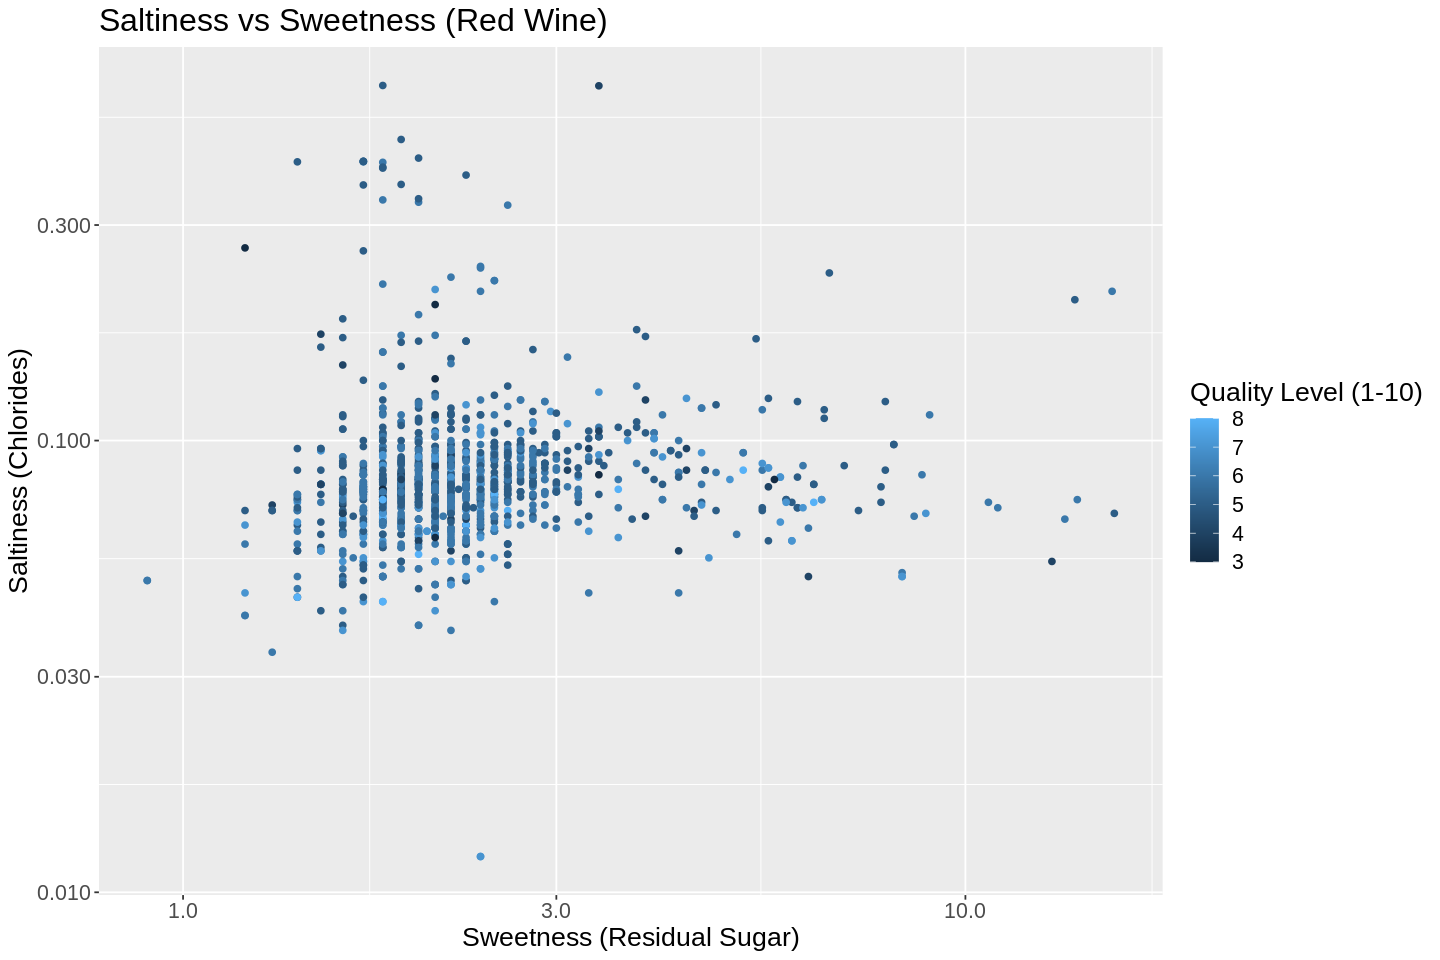

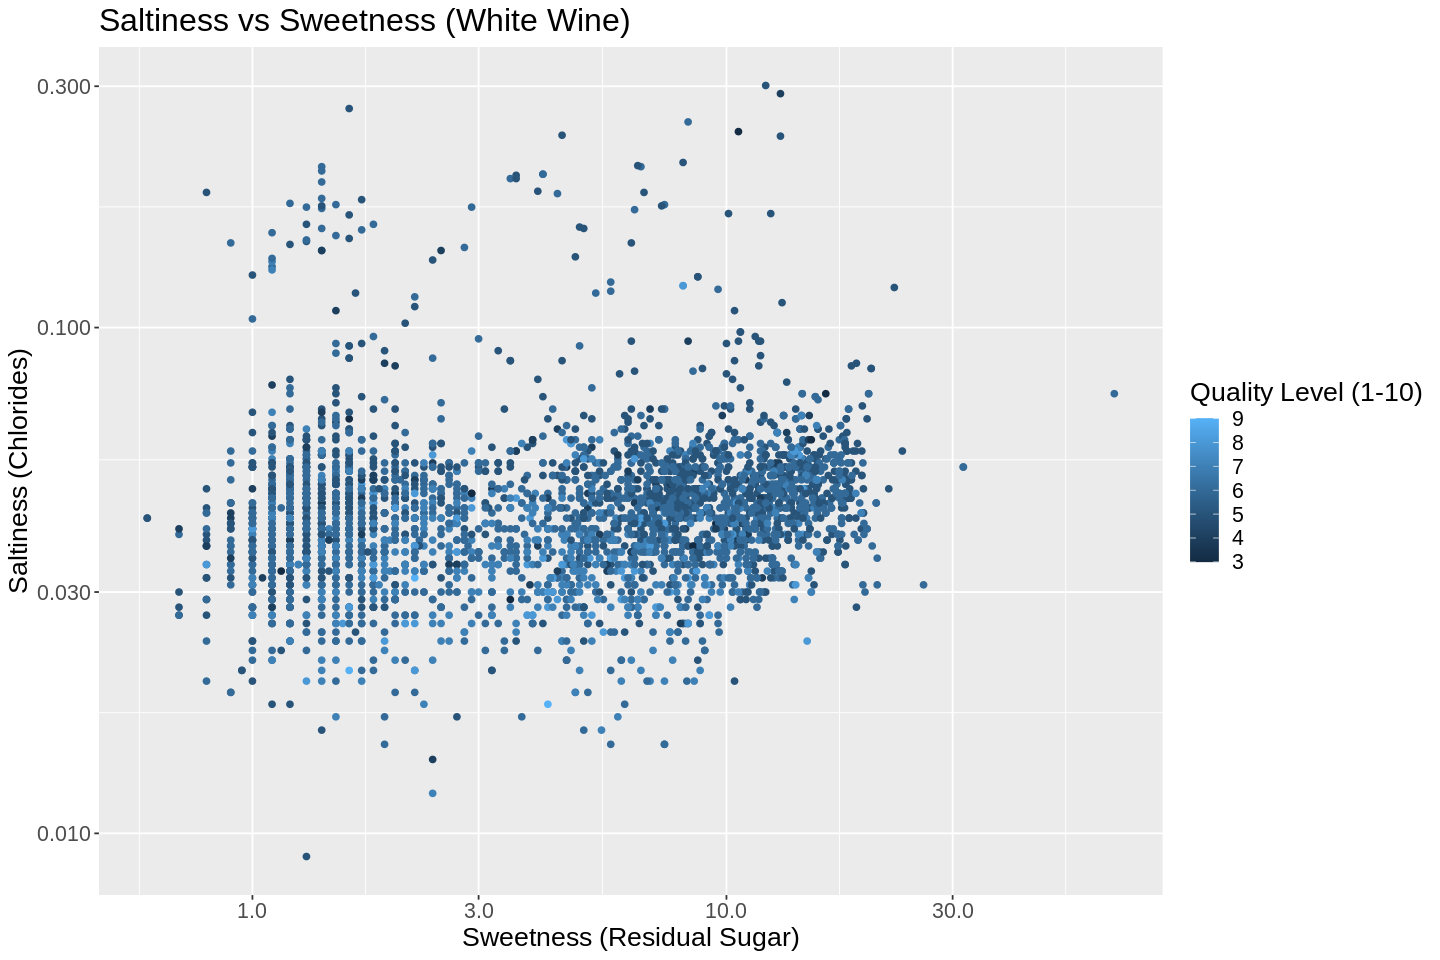

In [55]:
#Plotting sugar levels and saltiness flavour (Chloride levels) and seeing how they relate to quality

sugar_chloride_plot_r <-ggplot(red_train, aes(x = residual_sugar, y = chlorides, colour = quality)) +
    ggtitle("Saltiness vs Sweetness (Red Wine)") +
    geom_point() +
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma()) +
    labs(x = "Sweetness (Residual Sugar)", y = "Saltiness (Chlorides)", colour = "Quality Level (1-10)") +
    theme(text = element_text(size = 16))

sugar_chloride_plot_r

#Let's look at whether this trend is similar in white wine

sugar_chloride_plot_w <-ggplot(white_train, aes(x = residual_sugar, y = chlorides, colour = quality)) +
    ggtitle("Saltiness vs Sweetness (White Wine)") +
    geom_point() +
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma()) +
    labs(x = "Sweetness (Residual Sugar)", y = "Saltiness (Chlorides)", colour = "Quality Level (1-10)") +
    theme(text = element_text(size = 16))

sugar_chloride_plot_w

There seems to be no real observed pattern between sugar and chloride levels and the quality the wine gets. We will have to look further on whether we will use these variables (in the foward selection process)